In [24]:
import sys

sys.path.append("../../src/stong_core_cython")
sys.path.append("../../")

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import unrestricted_hartree_fock
import restricted_hartree_fock
import basis_data
import importlib
import matrix
from scipy.constants import physical_constants
from scipy.optimize import minimize
from scipy.linalg import eigh

importlib.reload(restricted_hartree_fock)
importlib.reload(unrestricted_hartree_fock)
importlib.reload(basis_data)
importlib.reload(matrix)

from atom import *
from unrestricted_hartree_fock import *
from basis_data import *
from matrix import *
from restricted_hartree_fock import *

In [26]:
df = pd.read_csv("../make_base/sto_ng/sto_3g.csv")

H2のエネルギーの結合長依存性

In [27]:
def solve_H(zetas):
    atoms = [Atom("H", np.array([0.0, 0.0, 0.0]))]
    molecule = Molecule(atoms)
    basis_data = {"H": create_basis_data(df, zetas, 1, 0)}
    hartreefock = UnrestrictedHartreeFock(
        molecule, basis_data, max_iter=10000, tol=1e-10
    )
    hartreefock.scf()
    hartreefock.calculate_total_energy()
    results = hartreefock.get_results()
    return results, hartreefock


def solve_rhf(r, zetas):
    atoms = [Atom("H", np.array([0.0, 0.0, 0.0])), Atom("H", np.array([r, 0.0, 0.0]))]
    molecule = Molecule(atoms)
    basis_data = {"H": create_basis_data(df, zetas, 1, 0)}
    hartreefock = RestrictedHartreeFock(molecule, basis_data, max_iter=10000, tol=1e-10)
    hartreefock.scf()
    hartreefock.calculate_total_energy()
    results = hartreefock.get_results()
    return results, hartreefock


def solve_uhf(r, zetas, P_up=None, P_dn=None):
    atoms = [Atom("H", np.array([0.0, 0.0, 0.0])), Atom("H", np.array([r, 0.0, 0.0]))]
    molecule = Molecule(atoms)
    basis_data = {"H": create_basis_data(df, zetas, 1, 0)}
    hartreefock = UnrestrictedHartreeFock(
        molecule, basis_data, max_iter=10000, tol=1e-10
    )
    if P_up is not None:
        hartreefock.P_up = P_up
        hartreefock.P_dn = P_dn
    hartreefock.scf()
    hartreefock.calculate_total_energy()
    results = hartreefock.get_results()
    return results, hartreefock


def get_energy(r, zetas):
    results, _ = solve_uhf(r, zetas)
    return results["energy"] + 1 / r


def solve_rhf_ci(r, results, hartreefock):
    vec = results["vec"]
    ERI = hartreefock.ERI
    T = hartreefock.T
    V = hartreefock.V
    num_orb = 2
    ci_matrix = np.zeros((num_orb, num_orb))
    ci_matrix[0, 0] += 2 * np.einsum("ij, i,j", T, vec[:, 0], vec[:, 0])
    ci_matrix[0, 0] += 2 * np.einsum("ij, i,j", V, vec[:, 0], vec[:, 0])
    ci_matrix[0, 0] += np.einsum(
        "ijkl,i, j, k,l", ERI, vec[:, 0], vec[:, 0], vec[:, 0], vec[:, 0]
    )
    ci_matrix[1, 1] += 2 * np.einsum("ij, i,j", T, vec[:, 1], vec[:, 1])
    ci_matrix[1, 1] += 2 * np.einsum("ij, i,j", V, vec[:, 1], vec[:, 1])
    ci_matrix[1, 1] += np.einsum(
        "ijkl,i, j, k,l", ERI, vec[:, 1], vec[:, 1], vec[:, 1], vec[:, 1]
    )
    ci_matrix[0, 1] += np.einsum(
        "ijkl,i, j, k,l", ERI, vec[:, 0], vec[:, 1], vec[:, 0], vec[:, 1]
    )
    ci_matrix[1, 0] += np.einsum(
        "ijkl,i, j, k,l", ERI, vec[:, 1], vec[:, 0], vec[:, 1], vec[:, 0]
    )
    val, vec = eigh(ci_matrix)
    return val[0] + 1 / r

In [28]:
df_zetas["H"] = pd.DataFrame([1.24])

In [29]:
res, hartree_fock = solve_H([1.24])

Start SCF for Molecule(atoms=[Atom(symbol=H, atomic_number=1, position=[0. 0. 0.])])


In [30]:
rs = np.linspace(0.5, 6.0, 100)
es_uhf = []
es_ci = []
for i, r in enumerate(reversed(rs)):
    print(i)
    if i == 0:
        results, hartree_fock = solve_uhf(r, df_zetas["H"])
    else:
        results, hartree_fock = solve_uhf(r, df_zetas["H"], P_up=P_up, P_dn=P_dn)
    P_up = results["P_up"]
    P_dn = results["P_dn"]
    es_uhf.insert(0, results["energy"] + 1 / r)
    # es_ci.insert(0, solve_uhf_ci(r, results, hartree_fock))

0
Start SCF for Molecule(atoms=[Atom(symbol=H, atomic_number=1, position=[0. 0. 0.]), Atom(symbol=H, atomic_number=1, position=[6. 0. 0.])])
1
Start SCF for Molecule(atoms=[Atom(symbol=H, atomic_number=1, position=[0. 0. 0.]), Atom(symbol=H, atomic_number=1, position=[5.94444444 0.         0.        ])])
2
Start SCF for Molecule(atoms=[Atom(symbol=H, atomic_number=1, position=[0. 0. 0.]), Atom(symbol=H, atomic_number=1, position=[5.88888889 0.         0.        ])])
3
Start SCF for Molecule(atoms=[Atom(symbol=H, atomic_number=1, position=[0. 0. 0.]), Atom(symbol=H, atomic_number=1, position=[5.83333333 0.         0.        ])])
4
Start SCF for Molecule(atoms=[Atom(symbol=H, atomic_number=1, position=[0. 0. 0.]), Atom(symbol=H, atomic_number=1, position=[5.77777778 0.         0.        ])])
5
Start SCF for Molecule(atoms=[Atom(symbol=H, atomic_number=1, position=[0. 0. 0.]), Atom(symbol=H, atomic_number=1, position=[5.72222222 0.         0.        ])])
6
Start SCF for Molecule(atoms=[At

In [31]:
es_rhf = []
# es_ci = []
for i, r in enumerate(reversed(rs)):
    print(i)
    results, hartree_fock = solve_rhf(r, df_zetas["H"])
    es_rhf.insert(0, results["energy"] + 1 / r)
    es_ci.insert(0, solve_rhf_ci(r, results, hartree_fock))

0
Start SCF for Molecule(atoms=[Atom(symbol=H, atomic_number=1, position=[0. 0. 0.]), Atom(symbol=H, atomic_number=1, position=[6. 0. 0.])])
1
Start SCF for Molecule(atoms=[Atom(symbol=H, atomic_number=1, position=[0. 0. 0.]), Atom(symbol=H, atomic_number=1, position=[5.94444444 0.         0.        ])])
2
Start SCF for Molecule(atoms=[Atom(symbol=H, atomic_number=1, position=[0. 0. 0.]), Atom(symbol=H, atomic_number=1, position=[5.88888889 0.         0.        ])])
3
Start SCF for Molecule(atoms=[Atom(symbol=H, atomic_number=1, position=[0. 0. 0.]), Atom(symbol=H, atomic_number=1, position=[5.83333333 0.         0.        ])])
4
Start SCF for Molecule(atoms=[Atom(symbol=H, atomic_number=1, position=[0. 0. 0.]), Atom(symbol=H, atomic_number=1, position=[5.77777778 0.         0.        ])])
5
Start SCF for Molecule(atoms=[Atom(symbol=H, atomic_number=1, position=[0. 0. 0.]), Atom(symbol=H, atomic_number=1, position=[5.72222222 0.         0.        ])])
6
Start SCF for Molecule(atoms=[At

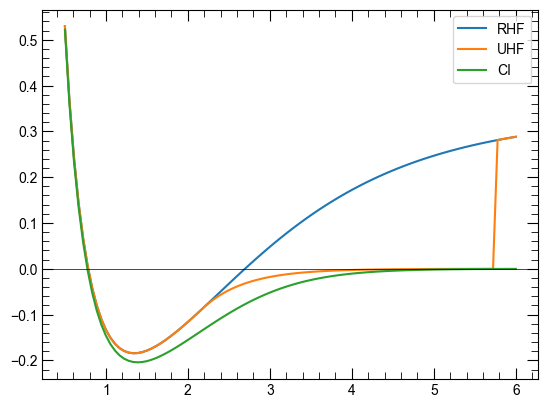

In [32]:
fig, ax = plt.subplots()
ax.plot(rs, es_rhf - 2 * res["energy"], label="RHF")
ax.plot(rs, es_uhf - 2 * res["energy"], label="UHF")
ax.plot(rs, es_ci - 2 * res["energy"], label="CI")
ax.legend()
ax.axhline(0, color="black", lw=0.5)
# ax.set_ylim(
#    -0.2,
# )
# ax.set_xlim([0.5, 3.4])
plt.show()
fig.savefig("hf_ci.pdf")

In [33]:
results, hartree_fock = solve_rhf(1.4, [1.24])
energy_rhf = results["energy"] + 1 / 1.4
energy_ci = solve_rhf_ci(1.4, results, hartree_fock)
print(energy_ci - energy_rhf)

Start SCF for Molecule(atoms=[Atom(symbol=H, atomic_number=1, position=[0. 0. 0.]), Atom(symbol=H, atomic_number=1, position=[1.4 0.  0. ])])
-0.02056471477881372


In [34]:
print(energy_ci)

-1.1372904679444567
